In [1]:
%matplotlib inline
import mdtraj as md
import sys
import argparse
import matplotlib.pyplot as plt
import numpy as np
import pickle
from Bio import SeqIO
import bz2
from itertools import islice
import peakutils
import scipy.optimize
import numpy as np
import pandas as pd
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 0.1
mpl.rcParams["font.size"] = 12
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : 12}

mpl.rc('font', **font)

In [2]:
NUC_LEN=147

In [3]:
def do_call_peaks(polstop):
    """Uses peakutils module to find the peak location."""
    indexes = []
    for exp in polstop:
        ind = peakutils.indexes(exp[:, 1], thres=0.2, min_dist=2)
        indexes.append(ind)
    return indexes


def find_closest(d):
    """Find the largest value in d."""
    max = 0
    for x in d:
        if d[x] > max:
            max = d[x]
    return max

In [4]:
def window(seq, n=2):
    "Return a sliding window (of width n) over data from the iterable."
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    """from http://stackoverflow.com/a/6822773"""
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [5]:
def rescale_zero_to_one(phase):
    max_v = phase[:, 1].max()
    min_v = phase[:, 1].min()
    d = max_v - min_v
    return (phase[:, 1] - min_v) / d

In [6]:
def do_compute_contacts(lys_dict):
    """Compute a profile showing where contacts are maximum."""
    contact = np.zeros((2, NUC_LEN))
    for i, d in enumerate(lys_dict):
        # we append on a different array if we pass n_bp limit
        if i >= NUC_LEN:
            j = i - NUC_LEN
            strand = 0
        else:
            j = i
            strand = 1
        max_v = find_closest(d)
        contact[strand, j] = max_v
    return contact

In [7]:
def do_pad_exp_and_overlap(exp, contacts):
    """Overlap (multiply) experimental and computed curves."""
    # add padding to exp to make arrays of same size
    # the fwd strans lacks data at the beginnig, and the rev at the end
    init_fwd = int(exp[0][0, 0]) - 1
    end_rev = NUC_LEN - int(exp[1][-1, 0])
    fwd_exp_padded = np.concatenate((np.zeros(init_fwd), exp[0][:, 1]))
    rev_exp_padded = np.concatenate((exp[1][:, 1], (np.zeros(end_rev))))
    overlap = []
    conv_1 = fwd_exp_padded * contacts[0, :]
    overlap.append(conv_1)
    conv_2 = rev_exp_padded * contacts[0, :]
    overlap.append(conv_2)
    
    not_negative = []
    not_negative.append([x if x > 0 else 0 for x in overlap[0]])
    not_negative.append([x if x > 0 else 0 for x in overlap[1]])
    
    padded_exp = []
    padded_exp.append(fwd_exp_padded)
    padded_exp.append(rev_exp_padded)

    return padded_exp, not_negative

In [8]:
def plot_data_3(list_dict, list_dict_notails, phase, experiment, sequence, peaks,
              outpng="log2FC_crosslink_w_MD_data.pdf"):
    """Do plot the data, 3 pannels: exp polstop, dna-lys contacts with/without histone tails."""

    num_plots = 3
    n_bp = len(phase)
    contact = np.zeros((2, n_bp))
    contact_notails = np.zeros((2, n_bp))
    x_ax = np.arange(1, n_bp + 1)
    f, ax = plt.subplots(num_plots, 1, sharex=True,
                         figsize=(cm2inch(17,10.6)), dpi=120, 
                         gridspec_kw = {'height_ratios':[3, 1, 1]})
    ax2 = ax[0].twiny()
    ax3 = ax[0].twinx()
    f.subplots_adjust(hspace=0)

    plt.locator_params(nbins=20)
    ax[1].set_axisbelow(True)
    strand = 0
    [i.set_linewidth(1.2) for i in ax[2].spines.itervalues()]
    [i.set_linewidth(1.2) for i in ax[1].spines.itervalues()]
    [i.set_linewidth(1.2) for i in ax[0].spines.itervalues()]
    
    for i, d in enumerate(list_dict):
        # we append on a different array if we pass n_bp limit
        if i >= n_bp:
            j = i - n_bp
            strand = 0
        else:
            j = i
            strand = 1
        max_v = find_closest(d)
        contact[strand, j] = max_v

    for i, d in enumerate(list_dict_notails):
        # we append on a different array if we pass n_bp limit
        if i >= n_bp:
            j = i - n_bp
            strand = 0
        else:
            j = i
            strand = 1
        max_v = find_closest(d)
        contact_notails[strand, j] = max_v
    
    prof = rescale_min_one_to_one(fit_sin(np.arange(147), phase))  
    
    ax3.plot(x_ax-1, prof, color="C7", linestyle="-", linewidth=1, alpha=0.4)
    ax3.set_ylabel("Major groove orientation")
    ax3.set_yticks([-1, -0.5, 0, 0.5, 1])
    
    ax[0].set_yticks([-1, -0.5, 0, 0.5, 1])
    
    ax[0].plot(experiment[0][:, 0]-1, experiment[0][:, 1],
            label="Forward strand", color="C0", linestyle="-")
    ax[0].plot(experiment[1][:, 0]-1, experiment[1][:, 1],
            label="Reverse strand", color="C1", linestyle="-")
    ax[0].set_ylabel("log2FC (crosslink/control)")
    ax[0].set_yticks([-3, 0, 3, 6, 9])
   
    ax[0].legend(ncol=4).get_frame().set_linewidth(0)
    ax[0].set_ylim([-2, 8.6])
    ax3.set_ylim([-1.6, 1.6])
    
    ax[1].plot(x_ax-1, contact[0, :],
            label="Forward strand", color="C0", linestyle="--")
    ax[1].plot(x_ax-1, contact[1, :],
            label="Reverse strand", color="C1", linestyle="--")
    
    ax[2].plot(x_ax-1, contact_notails[0, :],
            label="Forward strand", color="C0", linestyle="--")
    ax[2].plot(x_ax-1, contact_notails[1, :],
            label="Reverse strand", color="C1", linestyle="--")    
    
    ax[2].set_ylabel("Contact frequency")
    ax[2].set_xlabel("Distance from nucleosome dyad (bases)")

    
    ax1_tick_loc = [13, 33, 53, 73, 93, 113, 133]
    ax[2].set_xticks(ax1_tick_loc)
    ax[2].set_xticklabels([-60, -40, -20, 0, 20, 40, 60])

    ax[1].set_ylim([-0.2, 1.2])
    ax[2].set_ylim([-0.2, 1.2])
    
    ax[1].annotate("All histones", xy=(0,0.75))
    ax[2].annotate("Without histone tails", xy=(0,0.75))

    min_x_lim = -2
    max_x_lim = 149
    
    ax[0].set_xlim([min_x_lim, max_x_lim])
    ax[1].set_xlim([min_x_lim, max_x_lim])
    ax[2].set_xlim([min_x_lim, max_x_lim])
    ax3.set_xlim([min_x_lim, max_x_lim])
    ax2.set_xlim([min_x_lim, max_x_lim])
    
    # print the sequence on top
    ax2.set_xlim(ax[1].get_xlim())
    ax2_tick_loc = np.arange(NUC_LEN)
    ax2.set_xticks(ax2_tick_loc)
    mixed_seq = []
    for ff, rr in zip(sequence, sequence.complement()):
        mixed_seq.append("%s\n%s"%(rr, ff))
    ax2.set_xticklabels([b for b in mixed_seq], 
                        fontsize=5, 
                        family="monospace", weight="light")

    
    plt.savefig(outpng, bbox_inches='tight')
    return x_ax, contact

In [9]:
def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)

In [10]:
def read_data(pick_file, prof_file, exp):
    """Read all the data and return the numpy arrays.

    The phase data gets rescaled from 0 to 1
    """
    with open(pick_file, "r") as lh:
        list_dict = pickle.load(lh)
    phase_prof = np.genfromtxt(prof_file)
    rescaled_phase = rescale_zero_to_one(phase_prof)
    experiment = []
    experiment.append(np.genfromtxt(exp[0]))
    experiment.append(np.genfromtxt(exp[1]))
    return list_dict, rescaled_phase, experiment

In [11]:
def rescale_min_one_to_one(phase):
    """Rescale data from -1 to 1"""
    new_min = -1
    new_max = 1
    d_new = new_max - new_min
    max_v = phase.max()
    min_v = phase.min()
    d = max_v - min_v
    return (d_new * (phase - min_v)) / d + new_min

In [12]:
def fit_sin(tt, yy):
    """Fit sin to the input time sequence, and return fitting parameters.

    "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"
    from http://stackoverflow.com/a/42322656
    We are only interested in the fit
    """
    tt = np.array(tt)
    yy = np.array(yy)
    # assume uniform spacing
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))
    Fyy = abs(np.fft.fft(yy))
    # excluding the zero frequency
    guess_freq = abs(ff[np.argmax(Fyy[1:]) + 1])
    guess_amp = np.std(yy) * 2.**0.5
    guess_offset = np.mean(yy)
    guess = np.array(
        [guess_amp, 2. * np.pi * guess_freq, 0., guess_offset])

    def sinfunc(t, A, w, p, c): return A * np.sin(w * t + p) + c
    popt, pcov = scipy.optimize.curve_fit(sinfunc, tt, yy, p0=guess)
    A, w, p, c = popt

    return A * np.sin(w * tt + p) + c

In [13]:
def read_fasta(f):
    """Read the sequences."""
    if f.split(".")[-1] == "bz2":
        handle = bz2.BZ2File(f, "r")
    else:
        handle = open(f, "rU")
    records = list(SeqIO.parse(handle, "fasta"))
    return records

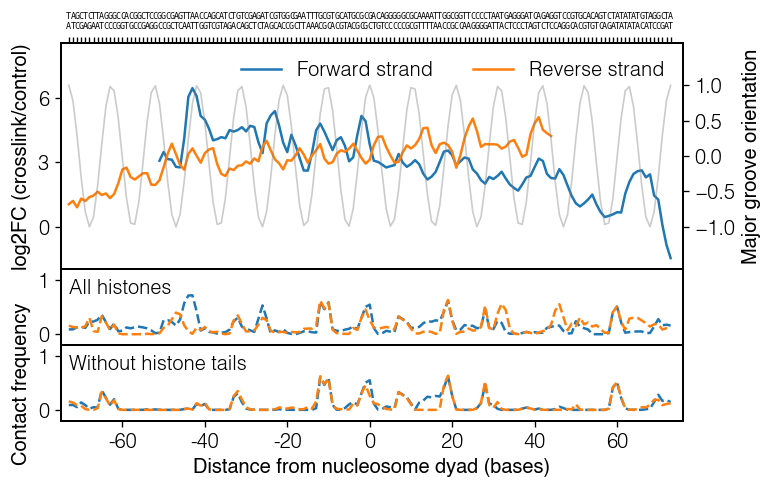

In [14]:
if __name__ == "__main__":
    """Plot the base-pair vs lys contacts as function of base pair position.

    Read the base-pair vs lysine contact dictionary, the phase profile and the
    experimental data. Put everything into a plot and print out as png.
    """

    # reading in a pdb, the list of contacts, the phase profile, the experimental
    # polymerase stop log2FC (log(FC/control)) for fwd and reverse strands, and 
    # the sequence (Widom 601).
    pdb_x = md.load("first_nuc_res.pdb")
    ldict = "list_bp_lys_dict_tails.pkl"
    ldict_notails = "list_bp_lys_dict_notails.pkl"
    phase_data = "bp_phase_profile.txt"
    exp = ["poly_stop_newest_fwd.dat", "poly_stop_newest_rev.dat"]
    seqrec = read_fasta("widom601.fa")
    if len(seqrec) != 1:
        print "Please provide only one sequence"
        sys.exit(0)
    if len(seqrec[0].seq) != NUC_LEN:
        print "Hei, the length of the sequence should be ", NUC_LEN
        sys.exit(0)
    else:
        sequence = seqrec[0].seq

    outpng = "log2FC_crosslink_w_MD_data.pdf"
    lys_dict, phase_prof, experiment = read_data(ldict, phase_data, exp)
    lys_dict_notails, phase_prof, experiment = read_data(ldict_notails, phase_data, exp)
    contacts = do_compute_contacts(lys_dict)
    contacts_notails = do_compute_contacts(lys_dict_notails)
    padded_exp, overlap = do_pad_exp_and_overlap(experiment, contacts)
    padded_exp_notails, overlap_notails = do_pad_exp_and_overlap(experiment, contacts_notails)
    peaks = do_call_peaks(experiment)
    phase_sin = fit_sin(np.arange(NUC_LEN), phase_prof)
    x_ax, contact = plot_data_3(lys_dict, lys_dict_notails, phase_sin, experiment, sequence, peaks,
                               outpng)
    